In [2]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('..')
if p not in sys.path:
    sys.path.append(p)

from tools.e5tools import *;from tools.generalTools import *
from tools.generalTools import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [3]:
xr.set_options(display_style='text') 

# Functions, data

In [4]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [5]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')
hrchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [6]:
hrhgt = hrchannel.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3
def plotsection(hgt,figsize=(15,4)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot((1635-hgt.west_east)*3,hgt,color='k')
    return ax,ax.twinx()

def f(x):
    return np.sign(x)*x**2

def change_coords_eta(sim,w,center=1635,staggered=0):
    if staggered:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()
    else:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level','west_east':'distance_from_mtn'}).persist()

def change_coords_etav(sim,w,staggered=0):
    if staggered:
        return w.assign_coords({'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level'}).persist()
    else:
        return w.assign_coords({'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level'}).persist()

def change_coords_pl(sim,w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure','west_east':'distance_from_mtn'}).persist()

def change_coords_press(sim,w):
    return w.assign_coords({'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure'})

def change_coords_sfc(w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'}).persist()


In [17]:
qmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
qmean   = qmean.where(qmean >0.)  
tmean   = tmean.where(tmean >100.)  


In [18]:
tmean_s   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc')
qmean_s   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.QVAPOR.days50-200.nc')
tmean_s   = change_coords_eta(hrchannel,tmean_s  )
qmean_s   = change_coords_eta(hrchannel,qmean_s  )

## extra data - not sure if useful 

In [7]:
wmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
zmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.GHT_PL.days50-100.nc')

wmean   = wmean.where(wmean > -100)  
rhomean = rhomean.where(rhomean >0.)  
omegamean = -9.81*rhomean*wmean
zmean   = zmean.where(zmean >=0.)  

omegamean_p = change_coords_pl(hrchannel_p,omegamean)[1:-4]
zmean_p =     change_coords_pl(hrchannel_p,zmean)[1:-4]
tmean_p =     change_coords_pl(hrchannel_p,tmean)[1:-4]
qmean_p =     change_coords_pl(hrchannel_p,qmean)[1:-4]

In [8]:
lmchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/')
lmchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.precip.days0-200.nc')
lmchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [9]:
lmqmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.Q_PL.days50-200.nc')
lmtmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.T_PL.days50-200.nc')
lmqmean   = lmqmean.where(lmqmean >0.)  
lmtmean   = lmtmean.where(lmtmean >100.)
lmtmean_p = change_coords_pl(lmchannel_p,lmtmean)
lmqmean_p = change_coords_pl(lmchannel_p,lmqmean)

In [10]:
lmtmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.TEMP.days50-200.nc')
lmqmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.3km/diags/wrf.QVAPOR.days50-200.nc')
lmtmean_s   = change_coords_eta(hrchannel,lmtmean_s  ) 
lmqmean_s   = change_coords_eta(hrchannel,lmqmean_s  )

In [11]:
aqtmean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.T_PL.days50-100.nc')
aqqmean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.Q_PL.days50-100.nc')
aqqmean   = aqqmean.where(aqqmean >0.)  
aqtmean   = aqtmean.where(aqtmean >100.)
aqtmean_p = change_coords_pl(lmchannel_p,aqtmean)
aqqmean_p = change_coords_pl(lmchannel_p,aqqmean)

In [12]:
aqtmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.TEMP.days50-100.nc')
aqqmean_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.aquaplanet.3km/diags/wrf.QVAPOR.days50-100.nc')
aqtmean_s   = change_coords_eta(hrchannel,aqtmean_s  ) 
aqqmean_s   = change_coords_eta(hrchannel,aqqmean_s  )

In [8]:
def plot_skewt(T,q,plevs,skew,color,lbl):
    P = np.array(plevs)* units.hPa
    Tups = units.degK*np.array(T)
    qups = np.array(q)
    Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)

    skew.plot(P, Tups,color=color ,label=lbl + " T")
    skew.plot(P, Tdups,color=color , linestyle='--',label=lbl + " Tdew")

    #first non-nan index
    maxcape = np.argmax(~np.isnan(np.array(T)))
    try:
        profups = mpcalc.parcel_profile(P[maxcape:], Tups[maxcape], Tdups[maxcape]).to('degC')
        skew.plot(P[maxcape:], profups, color=color, linestyle=':'  ,label=lbl+ " parcel profile")
        #skew.shade_cape(P[maxcape:], Tups[maxcape:], profups,color=color)
        print(" CAPE = %.1f J/kg"%(mpcalc.cape_cin(P[maxcape:], Tups[maxcape:], Tdups[maxcape:],profups)[0]/units("J/kg")))
    except RuntimeError:
        print('no cape')
    
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 50)
    skew.ax.legend()
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)

# TRMM climatology & cross-section

In [68]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.ndimage import gaussian_filter, convolve
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [69]:
pr_trmm_all=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr.rename({'lat':'latitude','lon':'longitude'})*3600*24
pr_trmm_mean = pr_trmm_all.groupby("time.month").mean("time")
pr_trmm_plot= pr_trmm_mean.sel(latitude=slice(-30,30))
pr_trmm_plot.coords['longitude'] = (pr_trmm_plot.coords['longitude'] + 180) % 360 -180
pr_trmm_plot = pr_trmm_plot.sortby(pr_trmm_plot.longitude)
pr_trmm_plot_allm=pr_trmm_plot
pr_trmm_plot=pr_trmm_plot.mean('month')

In [70]:
#OROGRAPHY
orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665
orog_plot = orog.reindex(latitude=list(reversed(orog.latitude))).sel(latitude=slice(-30,30))
orog_plot.coords['longitude'] = (orog_plot.coords['longitude'] + 180) % 360 -180
orog_plot = orog_plot.sortby(orog_plot.longitude)
orog_plot=xr.apply_ufunc(gaussian_filter,orog_plot  ,kwargs={"sigma":1.5})

In [71]:
era5100u= e5_climatology("*_100u",years=range(2009,2019))
era5100v= e5_climatology("*_100v",years=range(2009,2019))

8.113097906112671
16.293551683425903


In [72]:
u100plot=era5100u.sel(latitude=slice(30,-30))
v100plot=era5100v.sel(latitude=slice(30,-30))

u100plot.coords['longitude'] = (u100plot.coords['longitude'] + 180) % 360 -180
u100plot = u100plot.sortby(u100plot.longitude)
v100plot.coords['longitude'] = (v100plot.coords['longitude'] + 180) % 360 -180
v100plot = v100plot.sortby(v100plot.longitude)


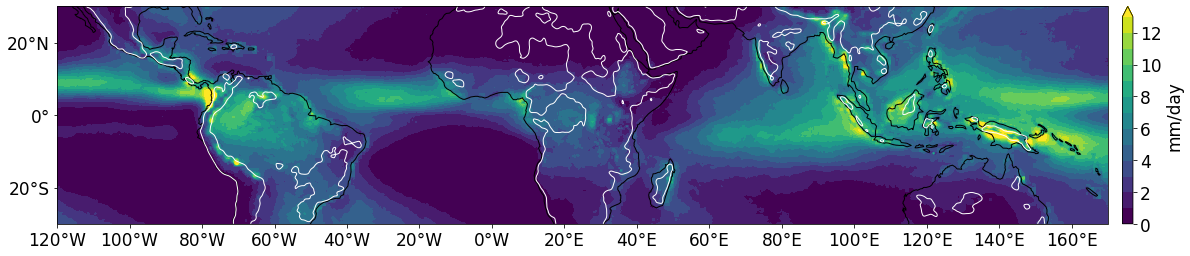

In [12]:
matplotlib.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(1,1,figsize=(25,4),subplot_kw={'projection': ccrs.PlateCarree()})
cf=pr_trmm_plot.sel(longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,13.5,1.),add_colorbar=False)#
orog_plot.sel(longitude=slice(-120,170)).plot.contour(ax=ax,levels=[500.],colors='w',linewidths=[1])

ax.coastlines()
ax.set_ylim(-30,30)
ax.set_xlim(-120,170)
ax.set_title("")
ax.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
ax.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel("")
ax.set_ylabel("")

pad=.2;size="1%"

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cf, cax=cax,label='mm/day')

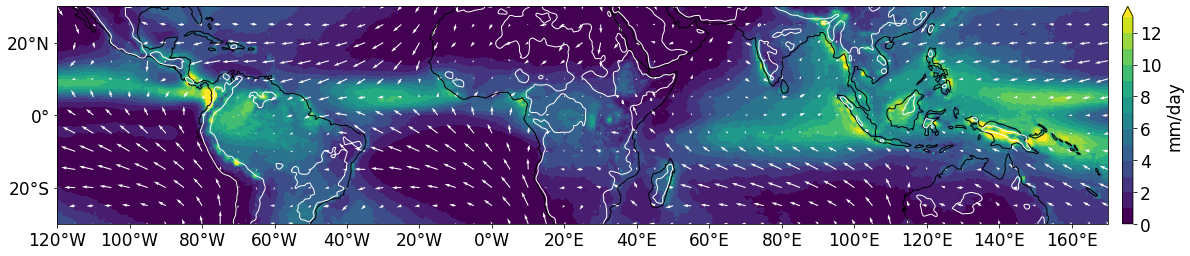

In [13]:
matplotlib.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(1,1,figsize=(25,4),subplot_kw={'projection': ccrs.PlateCarree()})
cf=pr_trmm_plot.sel(longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,13.5,1.),add_colorbar=False)#
orog_plot.sel(longitude=slice(-120,170)).plot.contour(ax=ax,levels=[500.],colors='w',linewidths=[1])

u=u100plot.sel(longitude=slice(-120,170)).mean('month')
v=v100plot.sel(longitude=slice(-120,170)).mean('month')
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=20
m=n
ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="w",width=0.001,scale=600)



ax.coastlines()
ax.set_ylim(-30,30)
ax.set_xlim(-120,170)
ax.set_title("")
ax.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
ax.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xlabel("")
ax.set_ylabel("")

pad=.2;size="1%"

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(cf, cax=cax,label='mm/day')

In [94]:
def plot_month(month,maxpr=20.,plot_winds=True):
    matplotlib.rcParams.update({'font.size': 17})
    fig, ax = plt.subplots(1,1,figsize=(25,4),subplot_kw={'projection': ccrs.PlateCarree()})
    cf=pr_trmm_plot_allm.sel(longitude=slice(-120,170),month=month).plot.contourf(ax=ax,levels=np.arange(0.,maxpr,1.),add_colorbar=False)#
    orog_plot.sel(longitude=slice(-120,170)).plot.contour(ax=ax,levels=[500.],colors='w',linewidths=[1])
    
    if plot_winds:
        u=u100plot.sel(longitude=slice(-120,170),month=month)
        v=v100plot.sel(longitude=slice(-120,170),month=month)
        X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
        Y = u.longitude.expand_dims({"latitude":u.latitude})
        n=20
        m=n
        ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="w",width=0.001,scale=600)
    
    
    
    ax.coastlines()
    ax.set_ylim(-30,30)
    ax.set_xlim(-120,170)
    ax.set_title("")
    ax.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
    ax.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    pad=.2;size="1%"
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    plt.colorbar(cf, cax=cax,label='mm/day')
    ax.set_title('%s mean'%(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][month-1]))
    return ax
#plot_month(7 ,25.)
#plot_month(11,18.)

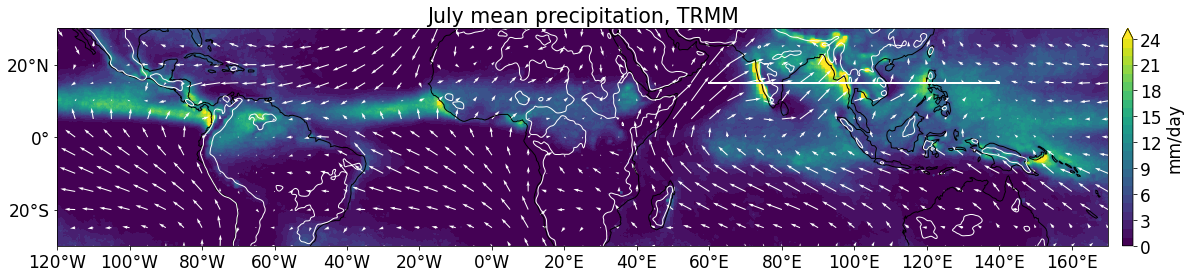

In [97]:
ax=plot_month(7 ,25.,True)
ax.set_title("July mean precipitation, TRMM")
ax.plot([60,140],[15,15],color='w',linewidth=2)

# Smith linear model

In [3]:
from orographicPrecipitation import smith_lm as slm

In [4]:
#OROGRAPHY
orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665

In [47]:
def upslope_model(month,lonlat):
    """compute total precip in a box given by lonlat, for a given month
        with Smith's linear model
        
        month : month for which compute the precip; format "YYYYMM"       
        lonlat : list, [lon1, lon2, lat1, lat2] specifying the box on which to perform calculation. 
            NOTE THAT 0 <= lon1 < lon2 <= 360 and -90 <= lat1 < lat2 <= 90        
    """
    
    lonlat2 = np.array(lonlat)+np.array([-1,1,-1,1]) #Do this to get rid of the border effects (high values of precip where the box crosses topography)

    #Start by retriving surface temperature, pressure, and 900 hpa winds
    #temp_surface = np.array([slm.retrieve_era5_monthly(month,lonlat2,'128_167_2t').mean(["latitude","longitude"])])
    #ps =           np.array([slm.retrieve_era5_monthly(month,lonlat2,'128_134_sp').mean(["latitude","longitude"])])
    temp_surface = slm.retrieve_era5_monthly(month,lonlat2,'128_167_2t')
    u900 = slm.retrieve_era5_monthly(month,lonlat2,'*_10u')
    v900 = slm.retrieve_era5_monthly(month,lonlat2,'*_10v')
    
    #compute elevation and dx, dy
    elevation = orog.sel(longitude=slice(lonlat2[0],lonlat2[1]),latitude=slice(lonlat2[3],lonlat2[2]))
    coslat = np.cos(np.array(elevation.latitude[0])*np.pi/180.)
    m_per_degreelat = 6370*1e3*np.pi/180
    dx = coslat*m_per_degreelat*np.abs(np.array(elevation.latitude[1]-elevation.latitude[0]))
    dy = m_per_degreelat*np.abs(np.array(elevation.longitude[1]-elevation.longitude[0]))
    ddxelev = elevation.differentiate("longitude")/(m_per_degreelat*coslat)
    ddyelev = elevation.differentiate("latitude")/m_per_degreelat
    qs = qsat(temp_surface,1000)
    
    return np.maximum(86400*qs*(u900*ddxelev+v900*ddyelev),0.)


In [61]:
m_per_degreelat = 6370*1e3*np.pi/180
def full_linear_model_saturated_monthly(month,lonlat,fine_scale=False,lr_param=0.99,p0=0.):
    """compute total precip in a box given by lonlat, for a given month
        with Smith's linear model
        
        month : month for which compute the precip; format "YYYYMM"       
        lonlat : list, [lon1, lon2, lat1, lat2] specifying the box on which to perform calculation. 
            NOTE THAT 0 <= lon1 < lon2 <= 360 and -90 <= lat1 < lat2 <= 90        
    """
    
    lonlat2 = np.array(lonlat)+np.array([-1,1,-1,1]) #Do this to get rid of the border effects (high values of precip where the box crosses topography)

    #Start by retriving surface temperature, pressure, and 900 hpa winds
    temp_surface = np.array([slm.retrieve_era5_monthly(month,lonlat2,'128_167_2t').mean(["latitude","longitude"])])
    ps =           np.array([slm.retrieve_era5_monthly(month,lonlat2,'128_134_sp').mean(["latitude","longitude"])])
    #u900 = np.array([retrieve_era5_monthly(month,lonlat2,'128_131_u').sel(level=900.).mean(["latitude","longitude"])])
    #v900 = np.array([retrieve_era5_monthly(month,lonlat2,'128_132_v').sel(level=900.).mean(["latitude","longitude"])])
    u900 = np.array([slm.retrieve_era5_monthly(month,lonlat2,'*_10u').mean(["latitude","longitude"])])
    v900 = np.array([slm.retrieve_era5_monthly(month,lonlat2,'*_10v').mean(["latitude","longitude"])])
        
    #compute elevation and dx, dy
    if fine_scale :
        elevation = orog_precise.sel(longitude=slice(lonlat2[0],lonlat2[1]),latitude=slice(lonlat2[3],lonlat2[2]))
    else :
        elevation = orog.sel(longitude=slice(lonlat2[0],lonlat2[1]),latitude=slice(lonlat2[3],lonlat2[2]))
    coslat = np.cos(np.array(elevation.latitude[0])*np.pi/180.)
    dx = coslat*m_per_degreelat*np.abs(np.array(elevation.latitude[1]-elevation.latitude[0]))
    dy = m_per_degreelat*np.abs(np.array(elevation.longitude[1]-elevation.longitude[0]))

    pr = slm.linear_model_saturated(temp_surface,ps,u900,v900,(lonlat[2]+lonlat[3])/2.,elevation,dx,dy,lr_param,p0)
    return pr.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2]))


def smithlm(month,latlon,p0):
    test=full_linear_model_saturated_monthly(month,latlon,fine_scale=False,lr_param=0.9,p0=p0/24)
    fig, ax = plt.subplots(1,1,figsize=(6,6),subplot_kw={'projection': ccrs.PlateCarree()})
    test.plot(ax=ax)
    orog.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2])).plot.contour(ax=ax,levels=[500.],colors='w',linewidths=[1])
    ax.coastlines()
    
    fig, ax = plt.subplots(1,1,figsize=(10,3))
    ax2=ax.twinx()
    test.sel(latitude=(latlon[2]+latlon[3])//2,method='nearest').plot(ax=ax2,color='g')
    orog.sel(longitude=slice(latlon[0],latlon[1]),latitude=(latlon[2]+latlon[3])//2).plot(ax=ax,color='k')

def upsm(month,latlon):
    test=upslope_model(month,latlon)
    fig, ax = plt.subplots(1,1,figsize=(6,6),subplot_kw={'projection': ccrs.PlateCarree()})
    test.plot(ax=ax)
    orog.sel(longitude=slice(latlon[0],latlon[1]),latitude=slice(latlon[3],latlon[2])).plot.contour(ax=ax,levels=[500.],colors='w',linewidths=[1])
    ax.coastlines()
    
    fig, ax = plt.subplots(1,1,figsize=(10,3))
    ax2=ax.twinx()
    test.sel(latitude=(latlon[2]+latlon[3])//2,method='nearest').plot(ax=ax2,color='g')
    orog.sel(longitude=slice(latlon[0],latlon[1]),latitude=(latlon[2]+latlon[3])//2).plot(ax=ax,color='k')
    

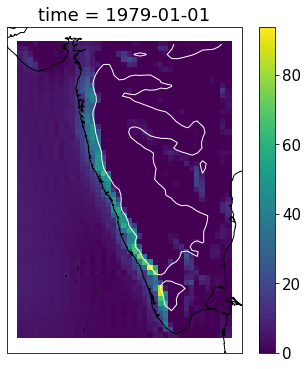

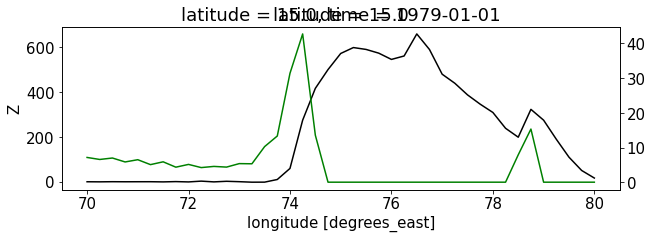

In [62]:
smithlm("200907",[70.,80.,8.,22.],0.)

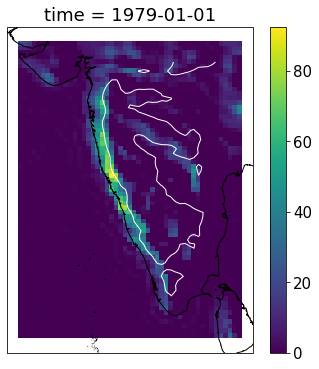

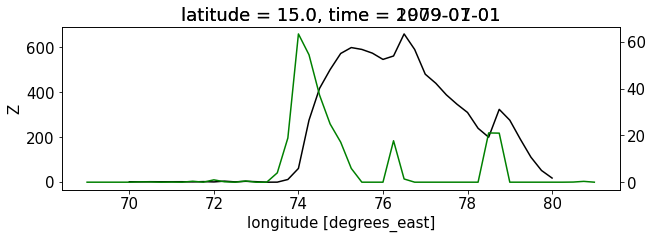

In [49]:
upsm("200907",[70.,80.,8.,22.])

In [37]:
qsat(300,1000)

0.022356421878245897

In [38]:
0.002*86400

172.8

In [127]:
def cross_section(lon1,lon2,lat,ax,month):
    ax2=ax.twinx()
    pr_trmm_plot_allm.sel(longitude=slice(lon1,lon2),month=month).sel(latitude=lat,method='nearest').plot(ax=ax2,color='g',label='Precipitation, TRMM',linewidth=2.5)#
    orog.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax,color='k',label='Surface elevation',linewidth=1.5)#
    ax.set_xlabel('')
    ticklon=range(lon1,lon2+1,10)
    ax.set_xticks(ticklon)
    ax.set_xticklabels(["%i°E"%t for t in ticklon])
    ax.set_ylabel('Z (m)')
    ax2.set_ylabel('precipitation (mm/day)')
    ax.set_title('Cross-section at %i°N'%lat,fontsize=20)
    ax.set_title('')
    ax2.set_title('')
    ax.set_xlim((lon1,lon2))
    #lines, labels = ax.get_legend_handles_labels()
    #lines2, labels2 = ax2.get_legend_handles_labels()
    #ax2.legend(lines + lines2, labels + labels2, loc=0)
    return ax2


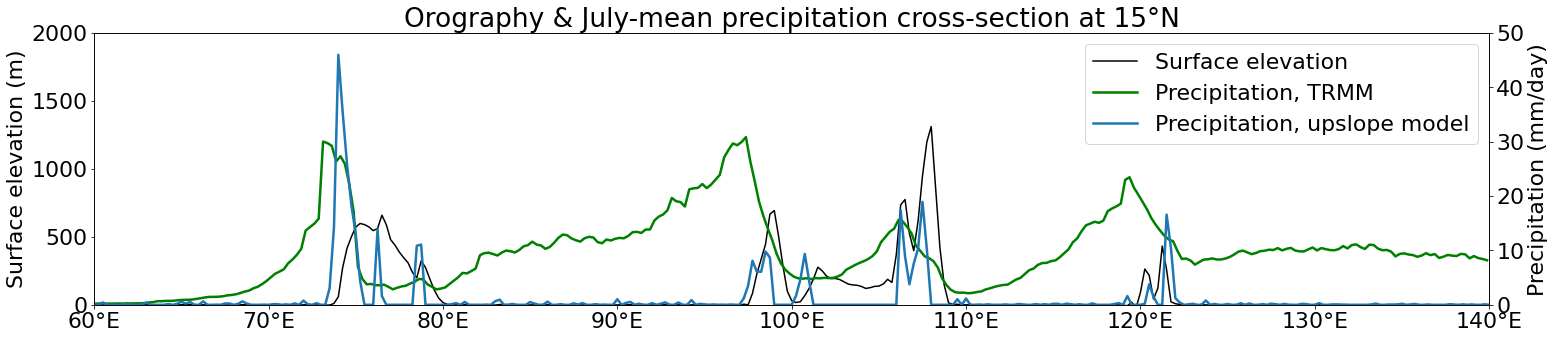

In [128]:
def linemonth(month):
    matplotlib.rcParams.update({'font.size': 22})
    fig,ax2 = plt.subplots(1,1,figsize=(25,5))
    #fig = plt.figure(figsize=(25,10))
    #spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [2, 1],figure=fig)
    #ax = fig.add_subplot(spec[0],projection= ccrs.PlateCarree())
    #ax2 = fig.add_subplot(spec[1])
    #
    #cf=pr_trmm_plot_allm.sel(longitude=slice(-120,170),month=month).plot.contourf(ax=ax,levels=np.arange(0.,25.,1.),add_colorbar=False)#,cbar_kwargs={'label':'mm/day'}
    #orog_plot.sel(longitude=slice(-120,170)).plot.contour(ax=ax,levels=[500.],colors='w',linewidths=[1.5])
    #ax.plot([60,140],[15,15],color='w',linewidth=2)
    #
    #ax.coastlines()
    #ax.set_ylim(-30,30)
    #ax.set_xlim(-120,170)
    #ax.set_title("")
    #ax.set_xticks(range(-120,170,20), crs=ccrs.PlateCarree())
    #ax.set_yticks(range(-20,30,20), crs=ccrs.PlateCarree())
    #lon_formatter = LongitudeFormatter(zero_direction_label=True)
    #lat_formatter = LatitudeFormatter()
    #ax.xaxis.set_major_formatter(lon_formatter)
    #ax.yaxis.set_major_formatter(lat_formatter)
    #ax.set_xlabel("")
    #ax.set_ylabel("")
    #
    #pad=.2;size="2%"
    #
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    #plt.colorbar(cf, cax=cax,label='mm/day')
    
    ax3=cross_section(60,140,15,ax2,month)
    ups = upslope_model('201007',[60.,140.,10.,20.])
    ups.sel(latitude=15.).plot(ax=ax3,label='Precipitation, upslope model',linewidth=2.5)
    #for a in ax2,ax3:
    #    divider2 = make_axes_locatable(a)
    #    cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
    #    cax2.remove()
    lines, labels = ax2.get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    ax2.set_ylim(0,2000)
    ax3.set_ylim(0,50)
    ax2.set_ylabel("Surface elevation (m)")
    ax3.set_ylabel("Precipitation (mm/day)")
    ax3.set_xlabel("Latitude")
    ax2.set_title("Orography & July-mean precipitation cross-section at 15°N")
    ax3.set_title("")
    
    
linemonth(7)

# WRF vs theory - precip

In [137]:
from scipy.integrate import cumtrapz
width = 10000e3
mwidth = 200e3
strength=0.9
mcenter = 5000e3
def domain():
    return np.linspace(0,width,100000)
def precip(cape,tau_c):
    """Compute a precipitation in mm/day (Pr = CAPE/tau_c/LatentHeat)"""
    Lc = 2.26e6 #latent heat of condensation in J/kg
    M = 8e3 #mass of troposphere in kg/m2
    conversion = 86400
    return conversion * M * cape / tau_c / Lc
def cape_analytical_Lx(x,f,L,CAPERCE,alpha):
    """Analytical solution to equation (3), with L and CAPERCE varying with x"""
    c = cumtrapz(1/(f*L),x,initial=0)
    return CAPERCE * np.exp(-c) * (1+cumtrapz(alpha/L*np.exp(c),x,initial=0))
def solve_Lx(f,L,CAPERCE,alpha,tau_c0):
    x = domain()
    capea = cape_analytical_Lx(x,f(x),L,CAPERCE,alpha)
    pr = precip(capea,tau_c0*f(x))
    return x,capea,pr
def elu(x):
    return (x<0)*(np.exp(np.minimum(x,200))-1)+(x>=0)*x
def f_sim_s(x,strength,dstrength):
    m = mcenter
    sigma = 1.5*mwidth/2
    gauss = 1 - strength*np.exp(-(x-m)**2/(2*sigma**2))
    arg=(-(5+(dstrength-5)/2)*elu(-(x-mcenter)/mwidth*3)-elu(0.5*(x-mcenter)/mwidth))
    downstream=dstrength*np.exp(arg)/np.exp(arg).max()
    return gauss+downstream
L=500e3
CAPERCE=1050.
tau_c0 = 80e3
x,CAPE_sim,pr_sim = solve_Lx(lambda x : f_sim_s(x,0.98,5),L,CAPERCE,1.,tau_c0)

In [134]:
hrchannelprecipmean=hrchannelprecip.isel(Time=slice(200,801)).mean(['Time','south_north']).load()

(-3000.0, 3000.0)

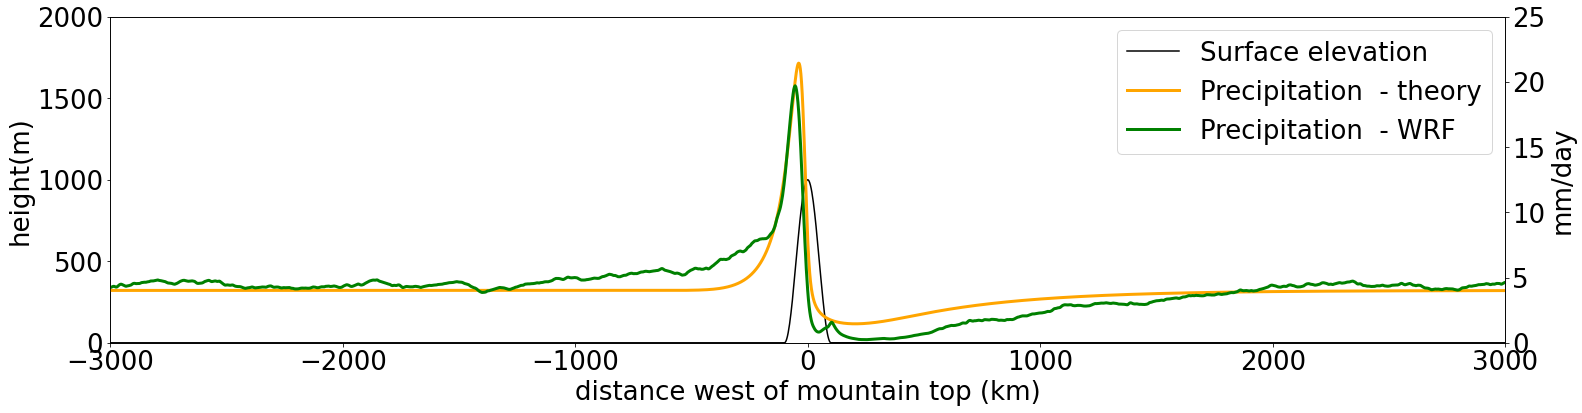

In [17]:
matplotlib.rcParams.update({'font.size': 26})
x = domain()
fig, ax = plt.subplots(1,1,figsize=(25,6))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.plot(hrdist,hrhgt,color='k',label='Surface elevation')
ax2=ax.twinx()

ax2.plot(x/1000-5000,pr_sim,label="Precipitation  - theory",color='orange',linewidth=3)
ax2.plot(hrdist,hrchannelprecipmean,label="Precipitation  - WRF",color='green',linewidth=3)

ax.set_ylim(0,2000)
ax2.set_ylim(0,25)
ax2.set_ylabel('mm/day')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax.set_xlim(-3000,3000)

#ax.set_title()


# Theory precip & CAPE

In [158]:
alpha/tauc

1.8749999999999998e-06

In [162]:
1050/80e3*8000*86400/2.26e6

4.014159292035398

In [19]:
alpha=0.2
b1hat=0.02
tauc=80e3
Ms=3500
Mh=500
u=10
L=u*tauc*Ms/Mh*b1hat/alpha

In [20]:
print(L/1000)

560.0


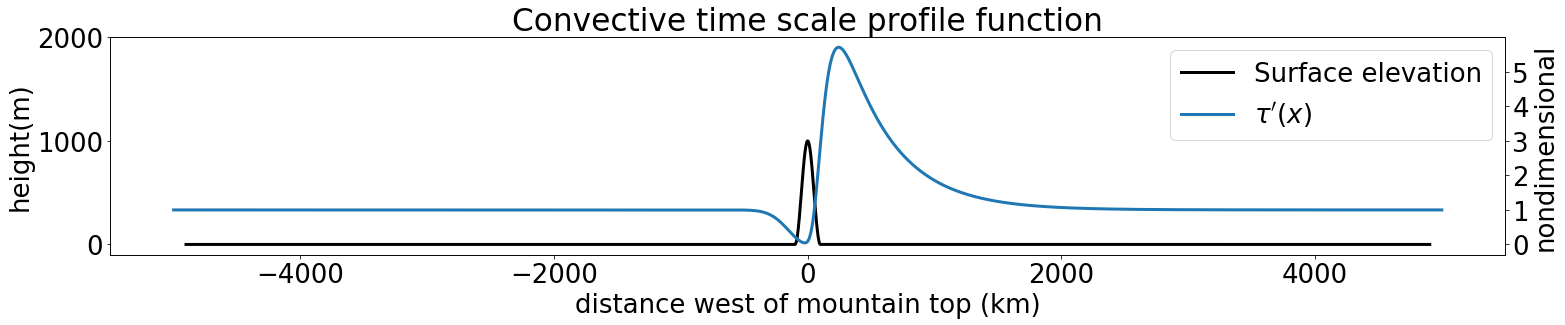

In [150]:
matplotlib.rcParams.update({'font.size': 26})
x = domain()
_,ax=plt.subplots(1,1,figsize=(25,4))
ax.plot(hrdist,hrhgt,color='k',label='Surface elevation',linewidth=3)
ax2=ax.twinx()
ax2.plot(x/1000-5000,f_sim_s(x,0.98,5),label=r"$\tau'(x)$",linewidth=3)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.set_title("Convective time scale profile function")
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax2.set_ylabel('nondimensional')
ax.set_ylim(-100,2000)
ax2.set_ylim(-100*6/2000,6)
ax2.set_yticks(range(6));None

(0.0, 25.0)

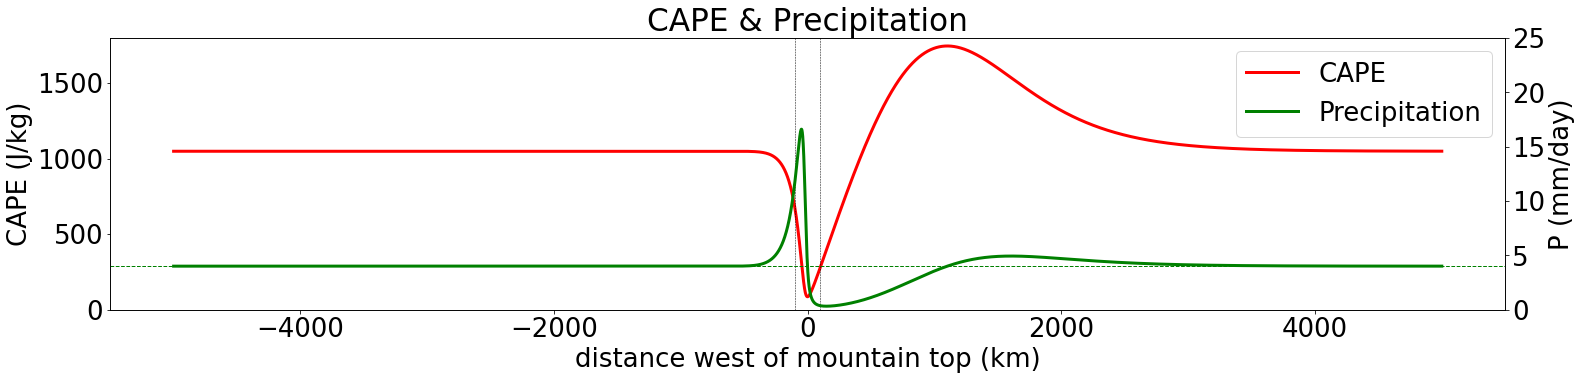

In [190]:
x,CAPE_sim,pr_sim = solve_Lx(lambda x : f_sim_s(x,0.98,5),400e3,CAPERCE,1.,tau_c0)
matplotlib.rcParams.update({'font.size': 26})
x = domain()

_,ax=plt.subplots(1,1,figsize=(25,5))
ax.plot(x/1000-5000,CAPE_sim,label="CAPE",color='r',linewidth=3)
ax2=ax.twinx()
ax2.plot(x/1000-5000,pr_sim,label="Precipitation",color='g',linewidth=3)

ax2.axhline(86400 * 8e3 * CAPERCE / tau_c0 / 2.26e6,color='g',linestyle='--',linewidth=1)
ax.axvline(- mwidth/2000,color='k', linestyle='--',linewidth=0.5)
ax.axvline(  mwidth/2000,color='k', linestyle='--',linewidth=0.5)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.set_title("CAPE & Precipitation")
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("CAPE (J/kg)")
ax2.set_ylabel('P (mm/day)')
ax.set_ylim(0,1800)
ax2.set_ylim(0,25)

# WRF Precip, CAPE & $\tau_c$

In [6]:
hrpr=hrchannelprecip.isel(Time=slice(200,801)).mean(['Time','south_north'])
hrcape=hrchannel_capecin[0].isel(Time=slice(200,801)).mean(['Time','south_north'])

(0.0, 25.0)

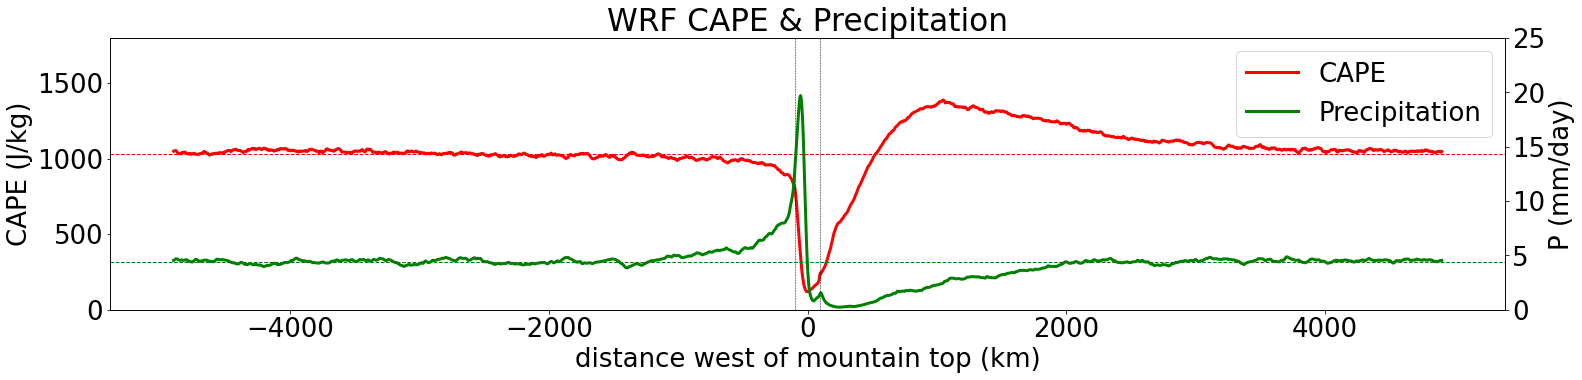

In [10]:
matplotlib.rcParams.update({'font.size': 26})

_,ax=plt.subplots(1,1,figsize=(25,5))
ax.plot(hrdist,hrcape,label="CAPE",color='r',linewidth=3)
ax2=ax.twinx()
ax2.plot(hrdist,hrpr,label="Precipitation",color='g',linewidth=3)

ax.axhline(hrcape[2000:3000].mean(),color='r',linestyle='--',linewidth=1)
ax2.axhline(hrpr[2000:3000].mean(),color='g',linestyle='--',linewidth=1)
ax.axvline(- 100,color='k', linestyle='--',linewidth=0.5)
ax.axvline(  100,color='k', linestyle='--',linewidth=0.5)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.set_title("WRF CAPE & Precipitation")
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("CAPE (J/kg)")
ax2.set_ylabel('P (mm/day)')
ax.set_ylim(0,1800)
ax2.set_ylim(0,25)

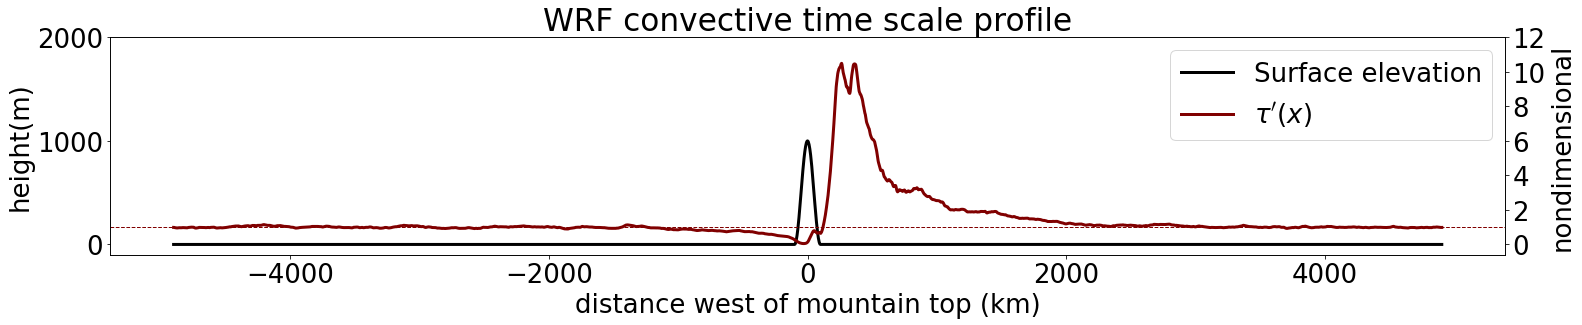

In [15]:
matplotlib.rcParams.update({'font.size': 26})
_,ax=plt.subplots(1,1,figsize=(25,4))
ax.plot(hrdist,hrhgt,color='k',label='Surface elevation',linewidth=3)
ax2=ax.twinx()
ax2.plot(hrdist,(hrcape/hrpr)/((hrcape/hrpr)[2000:3000].mean()),label=r"$\tau'(x)$",linewidth=3,color="maroon")
ax2.axhline(1.,linewidth=1,linestyle='--',color="maroon")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.set_title("WRF convective time scale profile")
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax2.set_ylabel('nondimensional')
ax.set_ylim(-100,2000)
ax2.set_ylim(-100*12/2000,12)
ax2.set_yticks(range(0,13,2));None

# Skew-Ts

In [150]:
def plot_skewt_close(T,q,plevs,skew,linestyle,lw=1.,legend=1,temponly=0):
    dp = (1000-float(plevs[0]))*100.
    plevs=np.array([1000.]+list(plevs))
    T=np.array([T[0]+dp/1004./(1e5/287/298)]+list(T))
    q=np.array([q[0]]+list(q))
    
    P = np.array(plevs)* units.hPa
    Tups = units.degK*np.array(T)
    qups = np.array(q)
    
    colorset=0
    colors=[("orange","dodgerblue","gray"),('r','b','k')][colorset]
    skew.plot(P, Tups,color=colors[0] ,label=legend*'Temperature',linewidth=lw,linestyle=linestyle)
    if temponly:
        skew.plot(P, Tups,color=colors[0] ,label='Upstream T',linewidth=lw,linestyle=linestyle)
    if not temponly:
        Tdups = mpcalc.dewpoint_from_specific_humidity(qups,Tups,P)
        skew.plot(P, Tdups,color=colors[1],linewidth=lw,linestyle=linestyle, label=legend*'Dew point')
        
        #Calculate full parcel profile and add to plot as black line
        profups = mpcalc.parcel_profile(P, Tups[0], Tdups[0]).to('degC')
        skew.plot(P, profups,color=colors[2],linewidth=lw,linestyle=linestyle, label=legend*'Parcel profile')
        #skew.shade_cape(P, Tups, profups)
        skew.ax.set_ylim(1000, 700)
        skew.ax.set_xlim(10, 30)
        skew.plot_dry_adiabats(linewidth=1.)
        skew.plot_moist_adiabats(linewidth=1.)
        print(mpcalc.cape_cin(P, Tups, Tdups,profups)[1]/units("J/kg"))

    
plevs=np.array(hrchannel_p.P_PL[0,1:-4].load())/100

In [151]:
t_rceu_mean = tmean.isel(west_east=slice(1635+3000//3,1635+3500//3)).mean('west_east').load()[1:-4]
q_rceu_mean = qmean.isel(west_east=slice(1635+3000//3,1635+3500//3)).mean('west_east').load()[1:-4]

t_200k_mean = tmean.isel(west_east=slice(1635+150//3,1635+200//3)  ).mean('west_east').load()[1:-4]
q_200k_mean = qmean.isel(west_east=slice(1635+150//3,1635+200//3)  ).mean('west_east').load()[1:-4]


-3.7303883108922298 dimensionless


Text(0, 0.5, 'hPa')

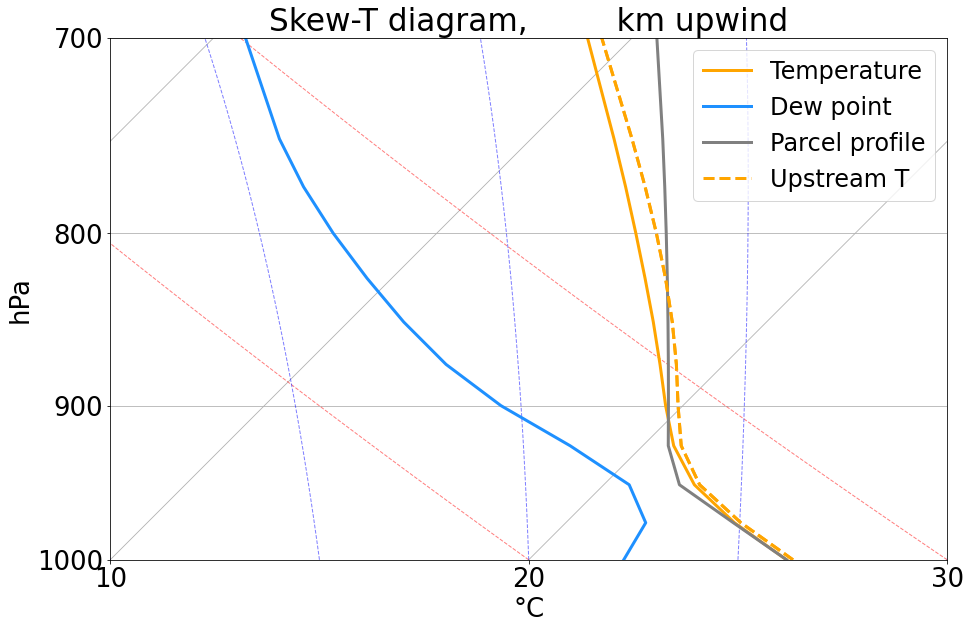

In [155]:
matplotlib.rcParams.update({'font.size': 26})
fig = plt.figure(figsize=(15,15))
skew = SkewT(fig, rotation=45)
plot_skewt_close(t_200k_mean, q_200k_mean, plevs, skew, '-',3.)
plot_skewt_close(t_rceu_mean, q_rceu_mean, plevs, skew, '--',3.,0,1)
#plot_skewt_close(t_rceu_mean, q_rceu_mean, plevs, skew, '-',3.)
plt.legend(fontsize=24,loc=1)
plt.title("Skew-T diagram,         km upwind")
plt.xlabel("°C")
plt.ylabel("hPa")

In [102]:
t_rceu_mean_s=tmean_s.sel(distance_from_mtn=slice(-2000,-2500)).mean('distance_from_mtn')
q_rceu_mean_s=qmean_s.sel(distance_from_mtn=slice(-2000,-2500)).mean('distance_from_mtn')

t_200k_mean_s=tmean_s.sel(distance_from_mtn=slice(-200,-250)).mean('distance_from_mtn')
q_200k_mean_s=qmean_s.sel(distance_from_mtn=slice(-200,-250)).mean('distance_from_mtn')

-1.4699328117137842 dimensionless
-1.0507818110905436 dimensionless


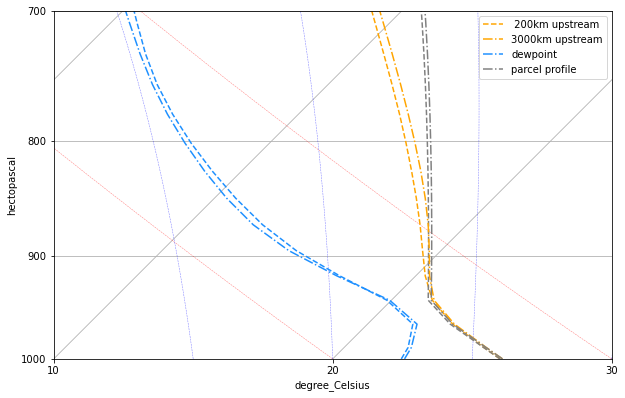

In [119]:
fig = plt.figure(figsize=(10,10))
skew = SkewT(fig, rotation=45)
plot_skewt_close(t_200k_mean_s, q_200k_mean_s, tmean_s.pressure[:,0], skew, '--', ' 200km upstream')
plot_skewt_close(t_rceu_mean_s, q_rceu_mean_s, tmean_s.pressure[:,0], skew, '-.', '3000km upstream',1)
plt.legend()